<a href="https://colab.research.google.com/github/nikkernoodle/shark-id/blob/models/Inceptionv3_baseline_model_with_dense_layers_and_dropout_layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORTS

In [1]:
#check tensorflow versions
!pip freeze | grep tensorflow

tensorflow==2.12.0
tensorflow-datasets==4.9.2
tensorflow-estimator==2.12.0
tensorflow-gcs-config==2.12.0
tensorflow-hub==0.13.0
tensorflow-io-gcs-filesystem==0.32.0
tensorflow-metadata==1.13.1
tensorflow-probability==0.20.1


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [19]:
from tensorflow.keras import layers, models, metrics, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import os, sys
import cv2
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from tensorflow.keras.applications.inception_v3 import preprocess_input

# PREPROCESSING

In [36]:
def load_sharks_data(loading_method):
    if loading_method == 'colab':
        data_path = '/content/drive/My Drive/shark-datasets/sharks'
    elif loading_method == 'direct':
        data_path = '../raw_data/sharks/'
    classes = {'basking': 0, 'blue': 1, 'hammerhead': 2, 'mako': 3, 'sand tiger': 4, 'tiger': 5, 'white' : 6,
               'blacktip': 7 , 'bull': 8, 'lemon':9 , 'nurse': 10, 'thresher': 11, 'whale': 12, 'whitetip': 13}
    imgs = []
    labels = []
    for (cl, i) in classes.items():
        images_path = [elt for elt in os.listdir(os.path.join(data_path, cl))]
        for img in tqdm(images_path[:300]):
            path = os.path.join(data_path, cl, img)
            if os.path.exists(path):
                image = Image.open(path)
                image = image.resize((229, 229))
                image = cv2.cvtColor(np.float32(image), cv2.COLOR_BGR2RGB)
                imgs.append(np.array(image))
                labels.append(i)

    X = np.array(imgs)
    num_classes = len(set(labels))
    y = to_categorical(labels, num_classes)

    # Finally we shuffle:
    p = np.random.permutation(len(X))
    X, y = X[p], y[p]

    first_split = int(len(imgs) /6.)
    second_split = first_split + int(len(imgs) * 0.2)
    X_test, X_val, X_train = X[:first_split], X[first_split:second_split], X[second_split:]
    y_test, y_val, y_train = y[:first_split], y[first_split:second_split], y[second_split:]

    return X_train, y_train, X_val, y_val, X_test, y_test, num_classes

In [37]:
X_train, y_train, X_val, y_val, X_test, y_test, num_classes = load_sharks_data("colab")

100%|██████████| 125/125 [00:05<00:00, 25.00it/s]


In [38]:
#Preprocessing
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)
X_test = preprocess_input(X_test)

# MODEL

## Define model

In [39]:
def load_model():

    model = InceptionV3(weights="imagenet", include_top=False, input_shape=X_train[0].shape)

    return model


In [40]:
model = load_model()
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 229, 229, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_658 (Conv2D)            (None, 114, 114, 32  864         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_658 (Batch  (None, 114, 114, 32  96         ['conv2d_658[0][0]']             
 Normalization)                 )                                                      

In [41]:
def set_nontrainable_layers(model):
    # Set the first layers to be untrainable
    model.trainable = False

    return model

In [42]:
model = set_nontrainable_layers(model)
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 229, 229, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_658 (Conv2D)            (None, 114, 114, 32  864         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_658 (Batch  (None, 114, 114, 32  96         ['conv2d_658[0][0]']             
 Normalization)                 )                                                      

### Actually build the model

In [43]:
def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainable, and add additional trainable layers on top'''
    # $CHALLENGIFY_BEGIN
    base_model = set_nontrainable_layers(model)
    flatten_layer = layers.Flatten()
    dense_layer1 = layers.Dense(500, activation='relu')
    dropout_layer1 = layers.Dropout(0.3)
    dense_layer2 = layers.Dense(400, activation='relu')
    dropout_layer2 = layers.Dropout(0.3)
    dense_layer3 = layers.Dense(300, activation='relu')
    dropout_layer3 = layers.Dropout(0.3)
    prediction_layer = layers.Dense(14, activation='softmax')
#creating dense layer 1 (changed from 50 to 500), dense layer 2 (400) and dense layer 3 (300) and dropout layers

    model = models.Sequential([
        base_model,
        flatten_layer,
        dense_layer1,
        dropout_layer1,
        dense_layer2,
        dropout_layer2,
        dense_layer3,
        dropout_layer3,
        prediction_layer
    ])
    # $CHALLENGIFY_END
    return model

In [44]:
model = add_last_layers(model)
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_7 (Flatten)         (None, 51200)             0         
                                                                 
 dense_28 (Dense)            (None, 500)               25600500  
                                                                 
 dropout_21 (Dropout)        (None, 500)               0         
                                                                 
 dense_29 (Dense)            (None, 400)               200400    
                                                                 
 dropout_22 (Dropout)        (None, 400)               0         
                                                                 
 dense_30 (Dense)            (None, 300)              

## Compile EfficientnetB2 + layers

In [45]:
def build_model():

    model = load_model()
    model = add_last_layers(model)

    opt = optimizers.Adam(learning_rate=1e-4)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  weighted_metrics=['accuracy'])

    return model


## Fit the model

In [46]:
model = build_model()
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_8 (Flatten)         (None, 51200)             0         
                                                                 
 dense_32 (Dense)            (None, 500)               25600500  
                                                                 
 dropout_24 (Dropout)        (None, 500)               0         
                                                                 
 dense_33 (Dense)            (None, 400)               200400    
                                                                 
 dropout_25 (Dropout)        (None, 400)               0         
                                                                 
 dense_34 (Dense)            (None, 300)              

In [47]:
model = build_model()

es = EarlyStopping(monitor = 'val_accuracy',
                   mode = 'max',
                   patience = 20,
                   verbose = 1,
                   restore_best_weights = True)
#patience changes from 5 to 20
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=16,
                    callbacks=[es])
#patience changes from 50 to 100
#batch_size changed from 16 to 32

Epoch 1/100
62/62 [==============================] - 14s 110ms/step - loss: 2.9815 - accuracy: 0.1772 - val_loss: 2.1001 - val_accuracy: 0.3366
Epoch 2/100
62/62 [==============================] - 5s 76ms/step - loss: 2.1583 - accuracy: 0.2902 - val_loss: 1.9324 - val_accuracy: 0.3689
Epoch 3/100
62/62 [==============================] - 4s 64ms/step - loss: 1.9709 - accuracy: 0.3432 - val_loss: 1.7641 - val_accuracy: 0.4498
Epoch 4/100
62/62 [==============================] - 4s 68ms/step - loss: 1.7492 - accuracy: 0.4063 - val_loss: 1.7222 - val_accuracy: 0.4498
Epoch 5/100
62/62 [==============================] - 5s 75ms/step - loss: 1.5750 - accuracy: 0.4837 - val_loss: 1.5483 - val_accuracy: 0.4951
Epoch 6/100
62/62 [==============================] - 4s 72ms/step - loss: 1.3804 - accuracy: 0.5448 - val_loss: 1.5369 - val_accuracy: 0.5275
Epoch 7/100
62/62 [==============================] - 4s 59ms/step - loss: 1.2123 - accuracy: 0.5916 - val_loss: 1.4750 - val_accuracy: 0.5210
Epoc

### Plot accuracy

In [48]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

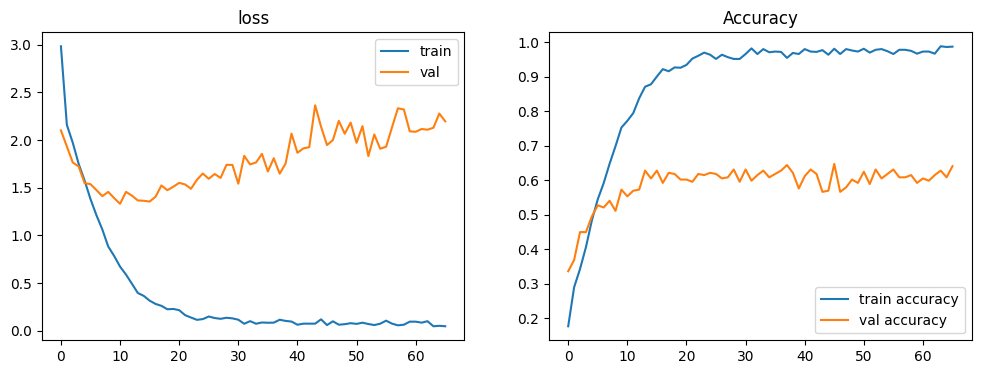

In [49]:
plot_history(history)

In [50]:
#overall accuarcy

res_vgg = model.evaluate(X_test, y_test)

test_accuracy_vgg = res_vgg[-1]


print(f"test_accuracy_vgg = {round(test_accuracy_vgg,2)*100} %")

# print(f"test_accuracy = {round(test_accuracy,2)*100} %")

print(f'Chance level: {1./num_classes*100:.1f}%')


9/9 [==============================] - 3s 168ms/step - loss: 1.9439 - accuracy: 0.5930
test_accuracy_vgg = 59.0 %
Chance level: 7.1%


In [51]:
predictions = model.predict(X_test)

9/9 [==============================] - 2s 75ms/step


In [52]:
y_pred = []

for pred in predictions:
  y_pred.append(np.argmax(pred))

In [53]:
y_test_argmax = []
for test in y_test:
  y_test_argmax.append(np.argmax(test))

### Classification Report for each class and overall

#### Create accuracy metric

In [54]:
# Return macro accuracy
accuracy = accuracy_score(y_test_argmax, y_pred)

# Return weighted accuracy
accuracy_bal = balanced_accuracy_score(y_test_argmax, y_pred)

accuracy, accuracy_bal

(0.5930232558139535, 0.5744668893198305)

In [55]:
from sklearn.metrics import classification_report
from sklearn import datasets, svm, metrics

In [56]:
#classification report

labels=['basking', 'blue', 'hammerhead', 'mako', 'sand tiger', 'tiger', 'white', 'blacktip', 'bull', 'lemon', 'nurse', 'thresher', 'whale', 'whitetip']

report = classification_report(y_test_argmax, y_pred, target_names=labels, output_dict=True)

# Convert the report to a pandas DataFrame
df = pd.DataFrame(report).transpose()
df = df.sort_values(by='precision', ascending=False)
df.reset_index(inplace=True)
df

,index,precision,recall,f1-score,support
0,whale,1.000000,0.833333,0.909091,24.000000
1,thresher,0.857143,0.692308,0.765957,26.000000
2,basking,0.818182,0.750000,0.782609,12.000000
3,blue,0.785714,0.611111,0.687500,18.000000
4,lemon,0.714286,0.238095,0.357143,21.000000
5,tiger,0.700000,0.500000,0.583333,14.000000
6,white,0.638889,0.920000,0.754098,25.000000
7,weighted avg,0.638392,0.593023,0.591029,258.000000
8,macro avg,0.629610,0.574467,0.579575,258.000000
9,nurse,0.625000,0.625000,0.625000,8.000000


### Confusion Matrix for class analysis

In [57]:
cm = confusion_matrix(y_test_argmax, y_pred)

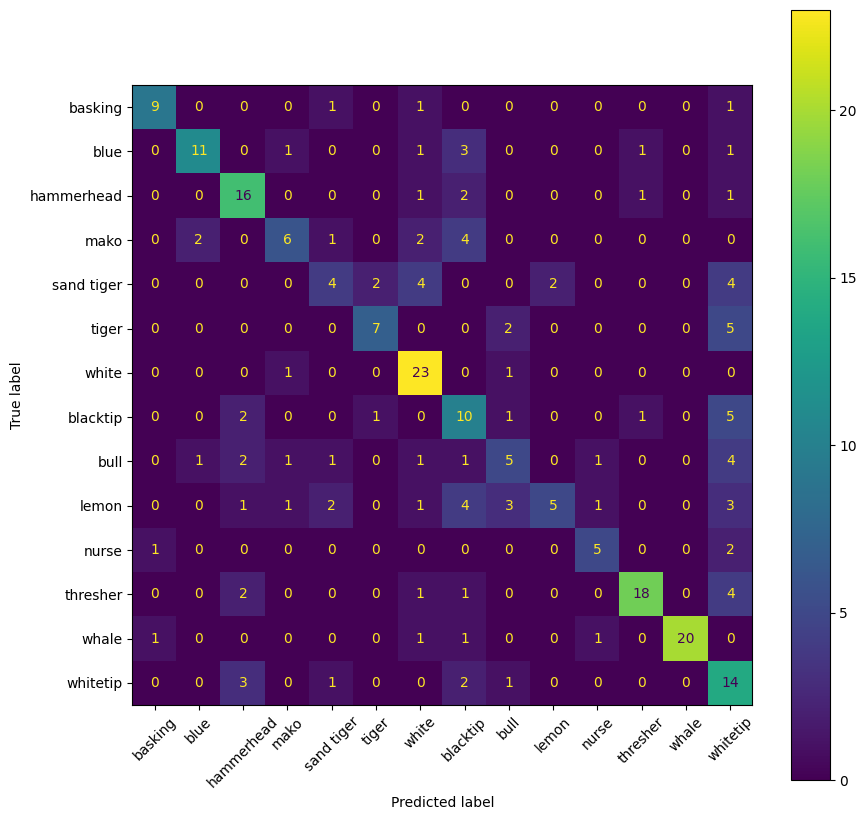

In [58]:
shark_labels = ['basking', 'blue', 'hammerhead', 'mako', 'sand tiger', 'tiger', 'white', 'blacktip', 'bull', 'lemon', 'nurse', 'thresher', 'whale', 'whitetip']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=shark_labels)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
ax.set_xticklabels(shark_labels, rotation=45)

plt.show()